# Synthetic sea surface elevation from directional wave spectrum

Author: Bia Villas Bôas - avillasboas@ucsd.edu

This notebook takes the most recent directional wave spectrum from [CDIP buoy 029](http://cdip.ucsd.edu/m/products/?stn=029p1) (Point Reyes) and constructs synthetic realizations of the corresponding sea surface using random phases. It uses the auxiliary functions `plot_dirSpec` and  `getmem`, both available in this repository.

In [43]:
from IPython.display import clear_output, HTML

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

from netCDF4 import Dataset, num2date
import time

from getmem import GetMem
from plot_dirSpec import  plot_dirSpec

Here we read the directional spectrum data directly from CDIP's website via OPeNDAP.

In [2]:
nc = Dataset('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/029p1_rt.nc', 'r')
print(nc.variables.keys())

odict_keys(['sourceFilename', 'waveTime', 'waveTimeBounds', 'waveFlagPrimary', 'waveFlagSecondary', 'waveHs', 'waveTp', 'waveTa', 'waveDp', 'wavePeakPSD', 'waveTz', 'waveSourceIndex', 'waveFrequency', 'waveFrequencyBounds', 'waveFrequencyFlagPrimary', 'waveFrequencyFlagSecondary', 'waveBandwidth', 'sstTime', 'sstTimeBounds', 'sstFlagPrimary', 'sstFlagSecondary', 'sstSeaSurfaceTemperature', 'sstSourceIndex', 'sstReferenceTemp', 'gpsTime', 'gpsTimeBounds', 'gpsStatusFlags', 'gpsLatitude', 'gpsLongitude', 'gpsSourceIndex', 'dwrTime', 'dwrTimeBounds', 'dwrSourceIndex', 'dwrBatteryLevel', 'dwrZAccelerometerOffset', 'dwrXAccelerometerOffset', 'dwrYAccelerometerOffset', 'dwrOrientation', 'dwrInclination', 'dwrBatteryWeeksOfLife', 'metaStationName', 'metaPlatform', 'metaInstrumentation', 'metaDeployLatitude', 'metaDeployLongitude', 'metaWaterDepth', 'metaDeclination', 'metaGridMapping', 'waveEnergyDensity', 'waveMeanDirection', 'waveA1Value', 'waveB1Value', 'waveA2Value', 'waveB2Value', 'waveC

We will use the most recent time (last value in the time dimension)

In [3]:
nctime = num2date(nc.variables['waveTime'][:], nc.variables['waveTime'].units)
print("The most recent time is:", nctime[-1])

The most recent time is: 2020-07-19 03:00:00


Now, we read the frequencies and energy spectrum 

In [4]:
freq = nc.variables['waveFrequency'][:] # wave frequency
energy = nc.variables['waveEnergyDensity'][-1]

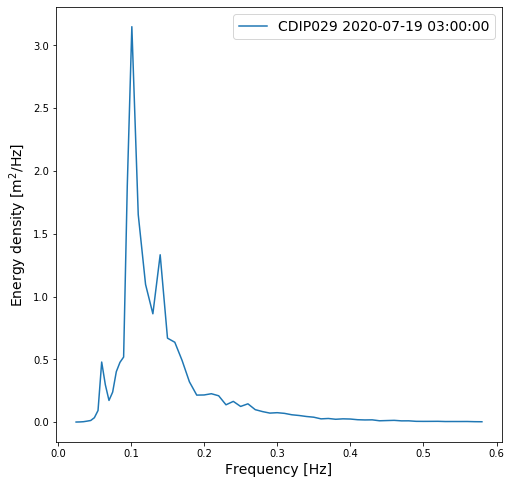

In [5]:
plt.figure(figsize=(8,8))
plt.plot(freq, energy, label='CDIP029 %s'%nctime[-1])
plt.ylabel("Energy density [m$^2$/Hz]", fontsize=14)
plt.xlabel("Frequency [Hz]", fontsize=14)
plt.legend(fontsize=14)

Operational wave buoys do not save the entire frequency-direction information. Instead, wave buoys usually save the first four direction Fourier coefficients. Here we use the Maximum Entropy Method to reconstruct the directional spectrum (see [Lygre et. al, 1986](https://journals.ametsoc.org/jpo/article/16/12/2052/6574) ).

In [6]:
a1 = nc.variables['waveA1Value'][-1]
b1 = nc.variables['waveB1Value'][-1]
a2 = nc.variables['waveA2Value'][-1]
b2 = nc.variables['waveB2Value'][-1]

Before recontructing the spectrum let's check some of the bulk wave parameters computed by CDIP:

In [7]:
print("Peak wave direction:", nc.variables['waveDp'][-1])
print("Peak wave period:", nc.variables['waveTp'][-1])
print("Significant wave height:", nc.variables['waveHs'][-1])

Peak wave direction: 311.125
Peak wave period: 9.876543
Significant wave height: 1.46


Now we reconstruct and plot the directional spectrum

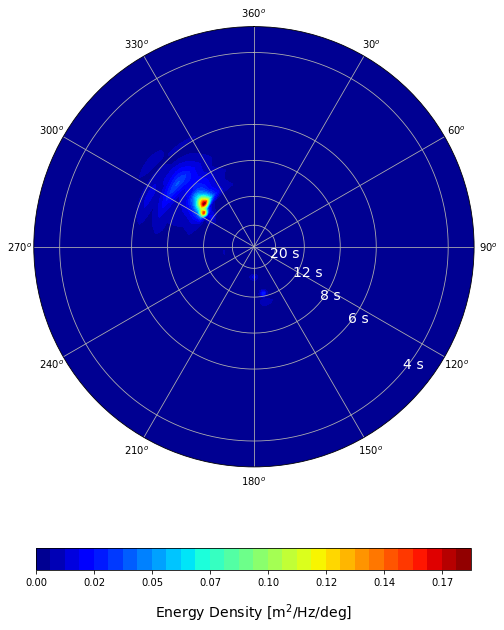

In [9]:
E = np.tile(energy, (360,1)).T
norm_mem= GetMem(a1,b1,a2,b2) # This uses the auxiliary function GetMem
dirSpec = E*norm_mem
dirSpec = dirSpec.T
plot_dirSpec(dirSpec, freq, directions=None, vmin=0,filename=None) # This uses the auxiliary function plot_dirSpec

We can check the significant wave height by computing:
$$H_s = 4 \left[\int_{0^\circ}^{360^\circ} \int_0^\infty  E(f,\theta) df d\theta\right]^{1/2}
$$ 



In [10]:
df = nc.variables['waveFrequencyBounds'][:,1] - nc.variables['waveFrequencyBounds'][:,0]
dth = 1 # delta theta in degrees
nfreq, ndir = E.shape
directions = np.arange(0, 360, dth)
dir_rad = np.radians(directions)

In [15]:
hs_reconstruct = 4*(np.sum(np.dot(dirSpec, df)*dth))**.5
print("The reconstructed significan wave height is:", hs_reconstruct)

The reconstructed significan wave height is: 1.4989849764816365


Now we create random phases and a horizontal grid to construct ou synthetic sea surface.

In [17]:
phases = np.random.random([ndir, nfreq])*2*np.pi # random phases
A = (dirSpec*df*dth)**.5 # Wave amplitudes from spectral densities

nx =200 # number of grid points in x
x = np.linspace(0,1000, nx)
y = x
xx, yy = np.meshgrid(x, y)

Now, we assume the linear deep-water dispersion relation:

$$
\sigma^2 = g k
$$

In [20]:
g = 9.81
sig = 2*np.pi*freq # going from linear freq to angular
k = sig**2/g

Now, we consider that the sea surface results from the linear superposition of all waves (all frequencies and directions).

$$
\eta(x, y, t) = \sum_i \sum_j A[\theta_i, \sigma_j] \ cos(k_x[i] x + k_y[i] y + \phi[i, j])
$$

In [21]:
zeta = np.zeros([nx,nx])
E = 0
for i in range(ndir):
    for j in range(nfreq):
        kx = k[j]*np.cos(dir_rad[i]+np.pi)
        ky = k[j]*np.sin(dir_rad[i]+np.pi)
        zeta += A[i,j]*np.cos(kx*xx + ky*yy + phases[i,j])
        E += A[i,j]**2 # total variance

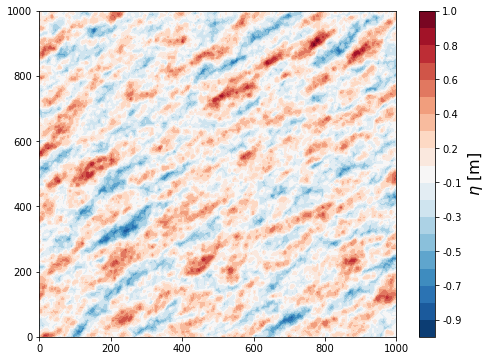

In [28]:
clim = np.max(abs(zeta))
lin = np.linspace(-clim, clim, 20)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zeta, lin, cmap = 'RdBu_r')
cbar = plt.colorbar(format='%.1f')
cbar.set_label('$\eta$ [m]', fontsize=16)

Now, we could have propagating waves if we add the frequency to the phase


$$
\eta(x, y, t) = \sum_i \sum_j A[\theta_i, \sigma_j] \ cos(k_x[i] x + k_y[i] y + \phi[i, j] + \sigma[j]t)
$$


This will probably take a while to run

In [30]:
nt = 20 
t = np.linspace(0, np.pi, nt);
zeta = np.zeros([nt, nx,nx])
E = np.zeros(nt)
for n in range(nt):
    for i in range(ndir):
        for j in range(nfreq):
            kx = ks[j]*np.cos(dir_rad[i]+np.pi)
            ky = ks[j]*np.sin(dir_rad[i]+np.pi)
            zeta[n] += A[i,j]*np.cos(kx*xx + ky*yy + phases[i,j] + sig[j]*t[n])
            E[n] += A[i,j]**2

In [ ]:
def animate(i):
    ax.contourf(xx, yy, zeta[i], lin, cmap='RdBu_r')

fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(xx, yy, zeta[0], lin, cmap='RdBu_r')
fig.colorbar(cs, format='%.1f')

anim = FuncAnimation(
    fig, animate, interval=200, frames=20)

In [42]:
rc('animation', html='html5')
HTML(anim.to_html5_video())